In [1]:
" Import the libraries " 

import os
import sys 
import math
import copy

import numpy as np
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
" Import the scripts of SD for Explaining "

absFilePath = os.path.dirname(os.path.dirname(os.getcwd()))
newPath = os.path.join(absFilePath, 'SplitSD4X')
sys.path.append(newPath)

from fill_missing_values import *
from missing_values_table import *
from neighbors_generation import *
from patterns_extraction import *
from performances import *
from subgroups_discovery import *
from sp_lime import *
from features_importance import *

In [3]:
" Import matplotlib and sns to display graphs and figures "

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import transforms
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

In [4]:
" Import the plot functions"
from plotFunctions.plotMSE import *
from plotFunctions.plotScore import *

In [5]:
" Define the functions to save and load data "
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [6]:
" LOAD THE DATA "

path = './saved_data/'
data_train = load_obj(path + 'data_train')
target_train = load_obj(path + 'target_train')
data_test  = load_obj(path  + 'data_test')
target_test = load_obj(path + 'target_test')
list_neigh = load_obj(path + 'list_neighbors')

" Number of instances to explain "
n = np.size(data_test,0) 

" Number of neighbors "
nb_neighs = np.size(list_neigh[0],0)

## Multi Layer Perceptron Model

In [7]:
" Sklearn MLP Classifier : "
mlp = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000,
                    solver='adam', random_state=1,
                    learning_rate_init=.1)

model_nt = mlp.fit(data_train, target_train)
target_pred_mlp = model_nt.predict(data_test)
print(f"{'The score of the Multi-Layer-Perceptron model is ' :<50}{': {}'.format(round(f1_score(target_test,target_pred_mlp,average='macro'),4))}")

The score of the Multi-Layer-Perceptron model is  : 0.9466


## Experiments

In [8]:
list_subgroups = load_obj(path + 'list_subgroups')
patterns = load_obj(path + 'patterns')
att_names = load_obj(path + 'att_names')
path = './data_to_plot/'

nb_classes = 4

###   Are subgroup models faithful to the black box ?

#### 1. MSE Error

In [9]:
f_mse = open(path + "mse.txt","w") 

* **Global white box** 

In [10]:
sse_wb = loss_global_wb (data_test,list_neigh,model_nt)
mse_wb = sse_wb / (n * nb_neighs)
print('The MSE Error of the global white box approach is : ','{:.2e}'.format(mse_wb))

"Store the results in the mse file"
f_mse.write("global\n") 
f_mse.write('{:.2e}'.format(mse_wb)+'\n')
f_mse.close()

The MSE Error of the global white box approach is :  1.67e-01


* **Submodular Pick LIME (SP LIME)** 

In [11]:
subrgoups_splime = sb_splime (data_test,list_neigh,model_nt)
sse_splime = loss_sd (subrgoups_splime,data_test,list_neigh,model_nt)
mse_splime = sse_splime / (n * nb_neighs)
print('The MSE Error of the SPLIME approach is : ','{:.2e}'.format(mse_splime))

The MSE Error of the SPLIME approach is :  8.53e-02


* **Local Models** 

In [12]:
sse_local_m = loss_local_models(n,list_neigh,model_nt)
mse_local_m = sse_local_m / (n * nb_neighs)
print('The MSE Error of the local models approach is : ','{:.2e}'.format(mse_local_m))

"Store the results in the mse file"
f_mse = open(path + "mse.txt","a") 
f_mse.write("local\n") 
f_mse.write('{:.2e}'.format(mse_local_m)+'\n')
f_mse.close()

The MSE Error of the local models approach is :  5.27e-04


* **SPLIT SD4X (Our Approach)** 

In [13]:
nb_models = [10, 20, 50, 100]
for j in nb_models :
    S = list_subgroups[j-2]
    sse_S = loss_sd (S,data_test,list_neigh,model_nt)
    mse_S = sse_S / (n * nb_neighs)
    print(f"{'The MSE Error of the SD4X approach ['+str(j)+' models]':<50}{'is : {:.2e}'.format(mse_S)}")

"Store the results in the mse file" 
nb_models_max = 100
f_mse = open(path + "mse.txt","a") 
f_mse.write("sd\n") 
f_mse.write('{:.2e}'.format(mse_wb)+'\n')
for i in range (0,nb_models_max-1) :
    S = list_subgroups[i]
    sse_S = loss_sd (S,data_test,list_neigh,model_nt)
    mse_S = sse_S / (n * nb_neighs)
    f_mse.write('{:.2e}'.format(mse_S)+'\n')
f_mse.close()

The MSE Error of the SD4X approach [10 models]    is : 1.84e-02
The MSE Error of the SD4X approach [20 models]    is : 4.22e-03
The MSE Error of the SD4X approach [50 models]    is : 1.02e-03
The MSE Error of the SD4X approach [100 models]   is : 5.49e-04


####  *MSE Error Graph*

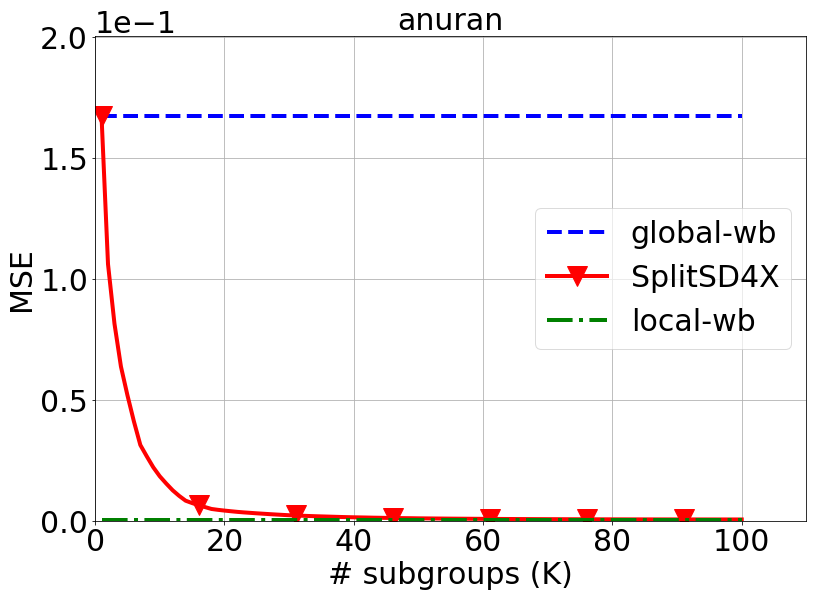

In [14]:
plotMSE('anuran',path)

#### 2. F1 Score

In [15]:
f_fscore = open(path + "f1score.txt","w") 

* **Global white box** 

In [16]:
fscore_wb = fscore_global_wb (data_test,n,list_neigh,model_nt,nb_classes)
print('The f-score of the global white box model is : ',round(fscore_wb,4))

"Store the results in the rsquared file"
f_fscore.write("A:") 
f_fscore.write(str(round(fscore_wb,4))+'\n')
f_fscore.close()

The f-score of the global white box model is :  0.6844


* **Submodular Pick LIME (SP LIME)** 

In [17]:
fscore_splime = fscore_sd (subrgoups_splime,data_test,list_neigh,model_nt,nb_classes)
print('The f-score given by the splime approach is : ',round(fscore_splime,4))

"Store the results in the rsquared file"
f_fscore = open(path + "f1score.txt","a") 
f_fscore.write("B:") 
f_fscore.write(str(round(fscore_splime,4))+'\n')
f_fscore.close()

The f-score given by the splime approach is :  0.7611


* **SPLIT SD4X (Our Approach)** 

In [18]:
S = list_subgroups[nb_models_max-2]
print("The number of subgroups is",len(S))

The number of subgroups is 100


In [19]:
nb_models = [10, 20, 50, 100]

" Store the results in the rsquared file "
f_fscore = open(path + "f1score.txt","a") 
char = 99 
for j in nb_models :
    S = list_subgroups[j-2]
    " Generation of the white box models for each subgroup" 
    fscore_sub_d = fscore_sd(S,data_test,list_neigh,model_nt,nb_classes)
    print(f"{'The fscore given by the SD4X approach ['+str(j)+' models]':<55}{'is : {}'.format(round(fscore_sub_d,4))}")
    f_fscore.write(chr(char).capitalize()+':')
    f_fscore.write(str(round(fscore_sub_d,4))+'\n')
    char += 1
    
f_fscore.close()    

The fscore given by the SD4X approach [10 models]      is : 0.9608
The fscore given by the SD4X approach [20 models]      is : 0.9939
The fscore given by the SD4X approach [50 models]      is : 0.9975
The fscore given by the SD4X approach [100 models]     is : 0.9981


* **Local Models** 

In [20]:
fscore_local_m = fscore_local_models (data_test,n,list_neigh,model_nt,nb_classes) 
print('The Rsquared given by the local models approach is : ',round(fscore_local_m,4))

" Store the results in the rsquared file "
f_fscore = open(path + "f1score.txt","a") 
f_fscore.write("G:") 
f_fscore.write(str(round(fscore_local_m,4))+'\n')
f_fscore.close()

The Rsquared given by the local models approach is :  0.9981


####  *F1 score Graph*

A : Global White Box
B : SPLIME
C : SD4X [10  models]
D : SD4X [20  models]
E : SD4X [50  models]
F : SD4X [100 models]
G : Local white box models


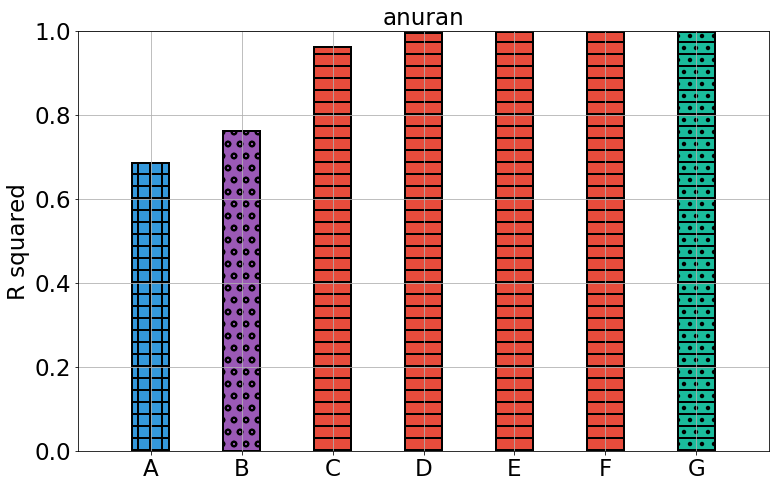

In [21]:
print('A : Global White Box')
print('B : SPLIME')
print('C : SD4X [10  models]')
print('D : SD4X [20  models]')
print('E : SD4X [50  models]')
print('F : SD4X [100 models]')
print('G : Local white box models')
plotOneScore('anuran',path)

###   Are subgroup models different from each other ?

#### 1. Silimarities between the models (cosinus distance)

In [22]:
" We generate the the white box models "
S = list_subgroups[nb_models_max-2]
W_ = lin_models_for_sim(S,data_test,list_neigh,model_nt,4)

In [23]:
" We calculate the cosinus distance between the models"
dist = similarity (W_,4)

In [24]:
" The average of the non similarity between the models"
# we define a treshold so that if the dist between two models is less than the thereshold, they are considered unsimilars
treshold = 0.5 
average_non_sim = avg_non_similar (dist,treshold)
print('The average of the non similarity between the models is',round(average_non_sim,2))

The average of the non similarity between the models is 0.95


####  *Heatmap of cosinus similarity*

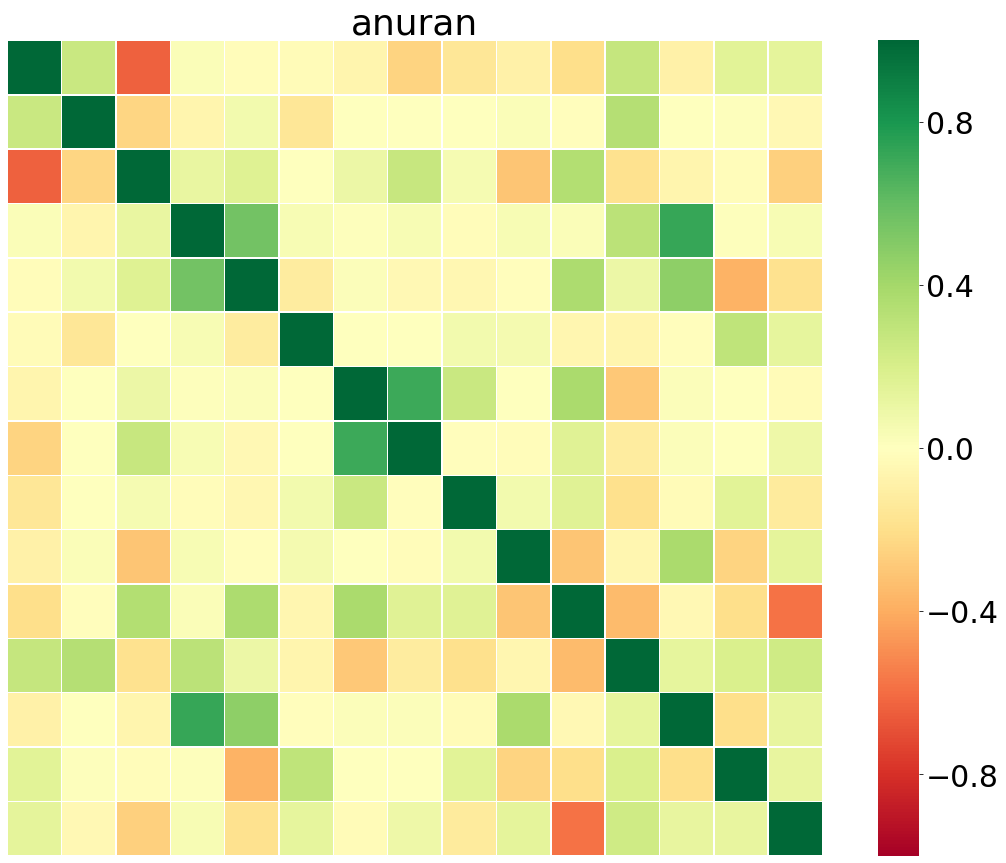

In [25]:
f, ax = plt.subplots(figsize=(20, 15))

" we set the window "
window = 15
ax = sns.heatmap(dist[:window,:window],linewidths=.5,yticklabels=False,xticklabels=False,
                 cmap ='RdYlGn',vmin=-1, vmax=1,square=True)
plt.title("anuran")
plt.savefig('FIGURES/heatmap_anuran.png')

###   Are subgroup models human interpretable?

#### 1. Features Importance

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
0.42 < MFCCs_ 4 <= 1.0  
0.13 < MFCCs_22 <= 0.43  
-0.5 < MFCCs_14 <= 0.46  



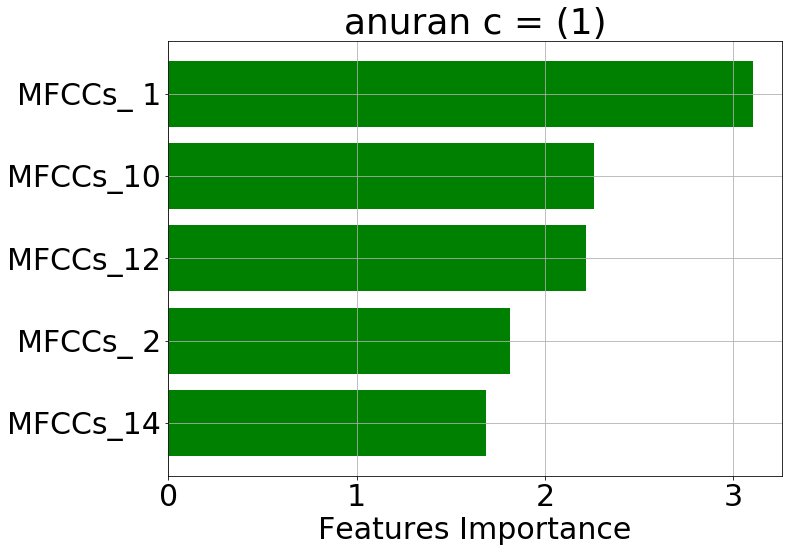

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.41 < MFCCs_ 8 <= 0.01  
0.03 < MFCCs_ 5 <= 0.53  
-0.01 < MFCCs_ 7 <= 0.62  



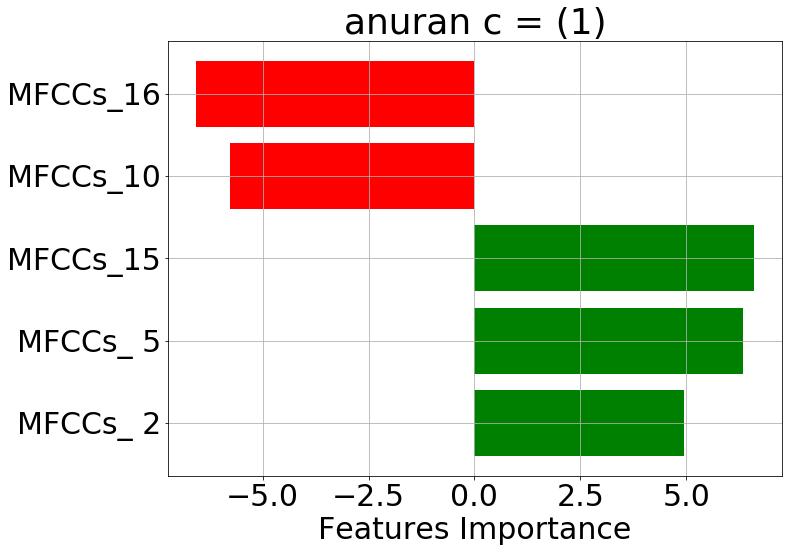

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
0.35 < MFCCs_ 3 <= 1.0  
-0.45 < MFCCs_ 9 <= -0.15  
-0.36 < MFCCs_12 <= 0.69  



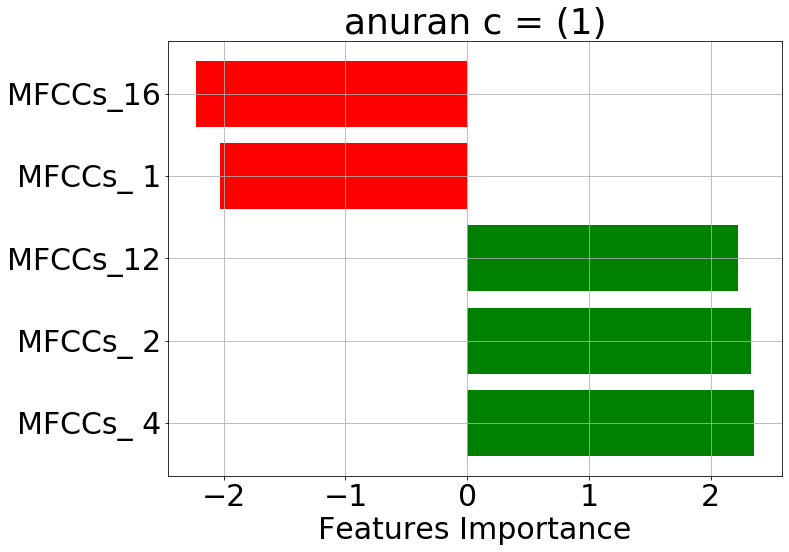

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
-0.3 < MFCCs_ 3 <= 0.35  
-0.01 < MFCCs_18 <= 0.43  
-0.37 < MFCCs_16 <= -0.05  
-0.17 < MFCCs_22 <= 0.43  



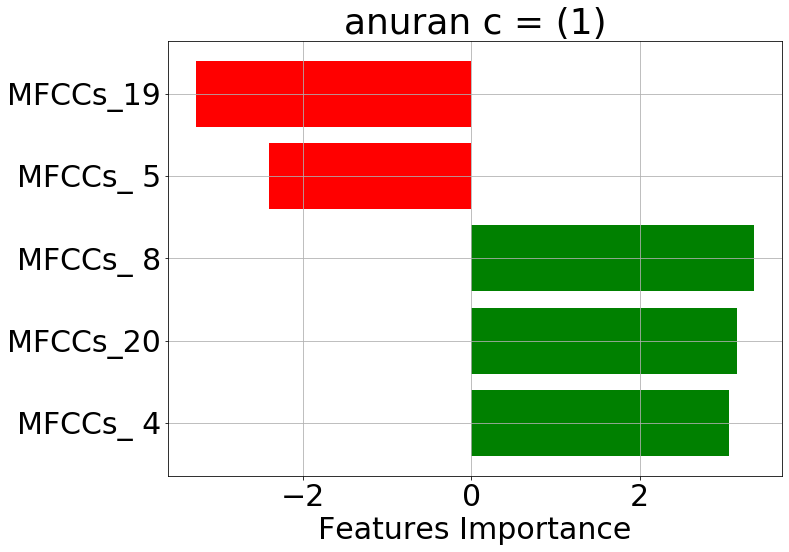

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
0.35 < MFCCs_ 3 <= 1.0  
-0.15 < MFCCs_ 9 <= 0.59  
-0.02 < MFCCs_16 <= 0.67  
-0.12 < MFCCs_ 8 <= 0.55  
-0.22 < MFCCs_ 6 <= 0.21  



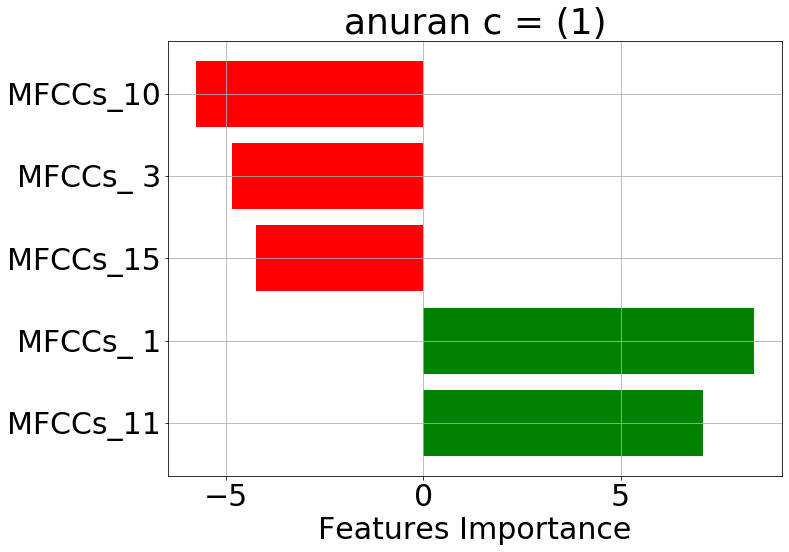

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
0.42 < MFCCs_ 4 <= 1.0  
-0.38 < MFCCs_22 <= 0.13  
-0.02 < MFCCs_16 <= 0.67  
0.23 < MFCCs_ 9 <= 0.59  
-0.73 < MFCCs_11 <= -0.18  



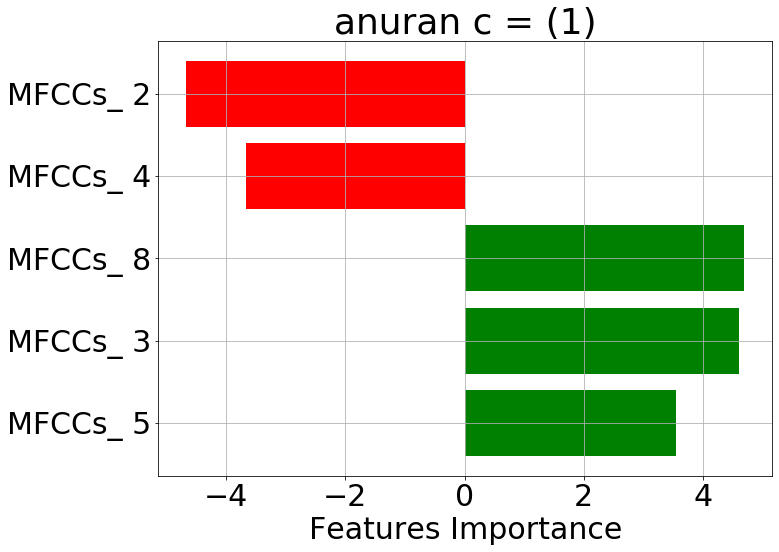

the subgroup description is :
-0.61 < MFCCs_13 <= -0.22  
-0.3 < MFCCs_ 3 <= 0.35  
-0.51 < MFCCs_18 <= -0.01  
-0.41 < MFCCs_ 8 <= -0.14  
-0.62 < MFCCs_ 2 <= 0.34  
-0.5 < MFCCs_10 <= 0.4  



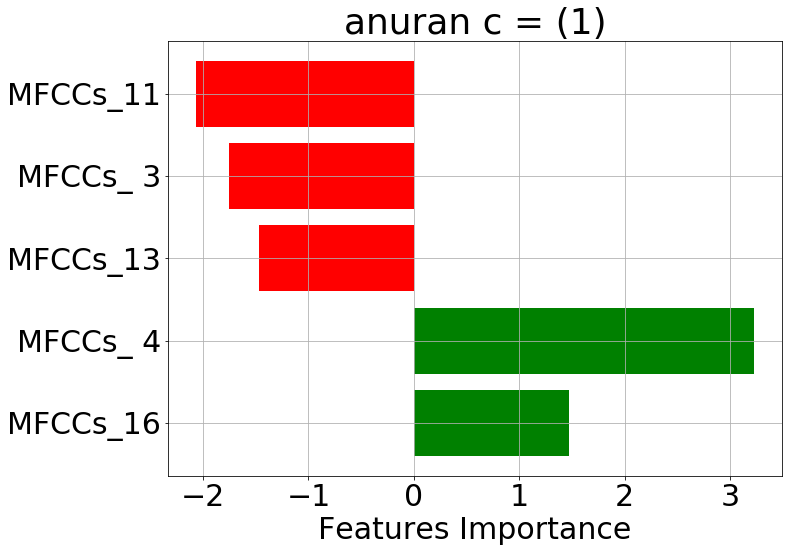

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.41 < MFCCs_ 8 <= -0.13  
-0.49 < MFCCs_ 5 <= 0.03  
0.13 < MFCCs_ 7 <= 0.62  
-0.04 < MFCCs_21 <= 0.39  
-0.26 < MFCCs_ 9 <= 0.59  



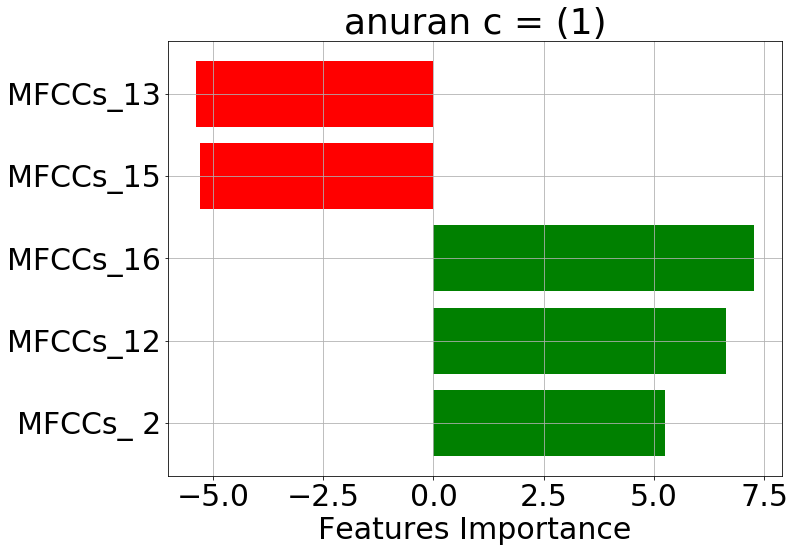

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.13 < MFCCs_ 8 <= 0.01  
-0.49 < MFCCs_ 5 <= 0.03  
-0.13 < MFCCs_14 <= 0.08  
-0.02 < MFCCs_22 <= 0.43  



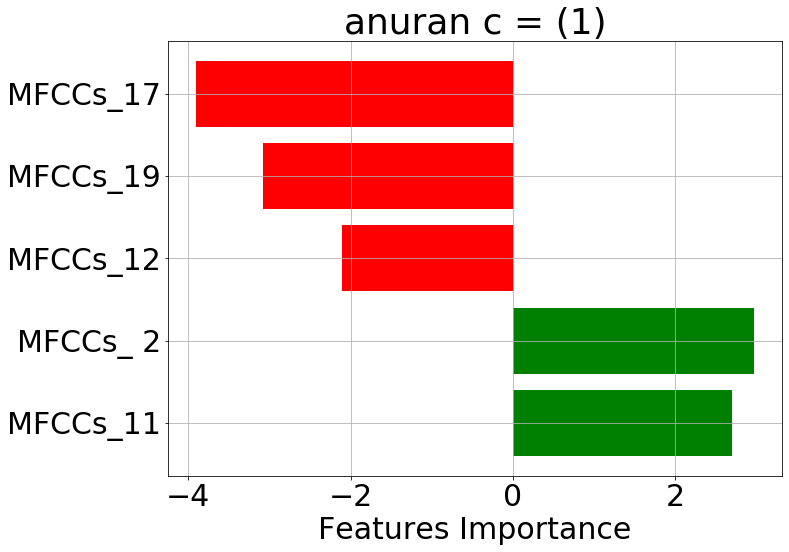

the subgroup description is :
0.13 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
-0.3 < MFCCs_ 3 <= 0.25  
-0.49 < MFCCs_ 5 <= 0.33  
-0.24 < MFCCs_10 <= 0.48  
-0.72 < MFCCs_15 <= -0.12  



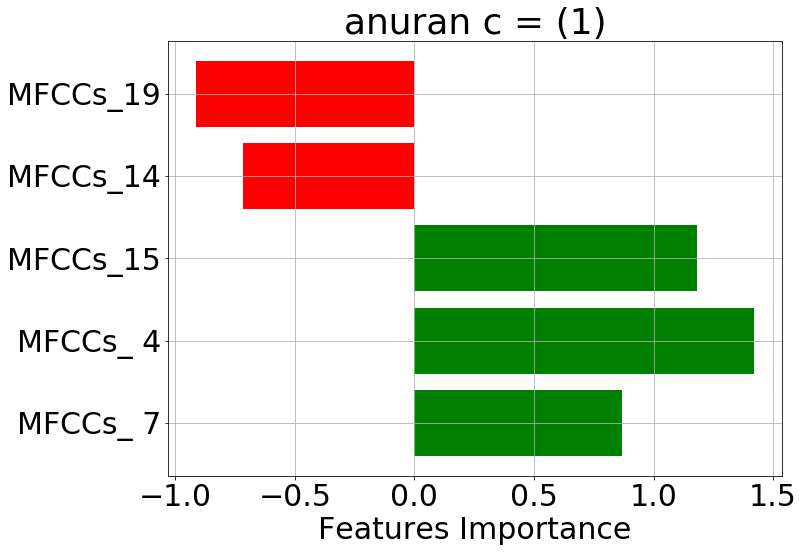

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
0.42 < MFCCs_ 4 <= 1.0  
0.13 < MFCCs_22 <= 0.43  
-0.5 < MFCCs_14 <= 0.46  



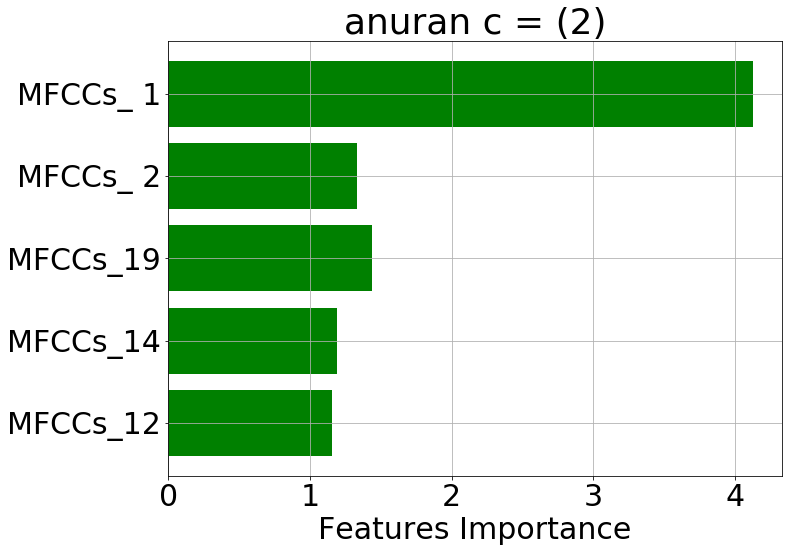

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.41 < MFCCs_ 8 <= 0.01  
0.03 < MFCCs_ 5 <= 0.53  
-0.01 < MFCCs_ 7 <= 0.62  



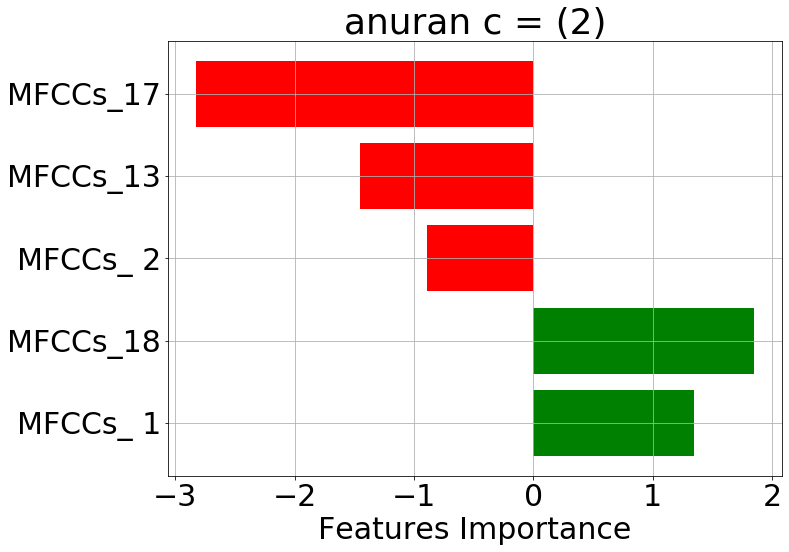

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
0.35 < MFCCs_ 3 <= 1.0  
-0.45 < MFCCs_ 9 <= -0.15  
-0.36 < MFCCs_12 <= 0.69  



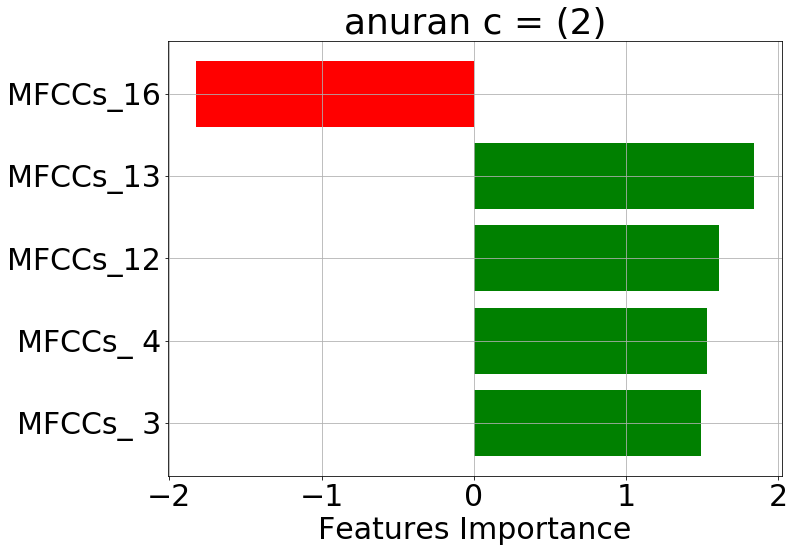

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
-0.3 < MFCCs_ 3 <= 0.35  
-0.01 < MFCCs_18 <= 0.43  
-0.37 < MFCCs_16 <= -0.05  
-0.17 < MFCCs_22 <= 0.43  



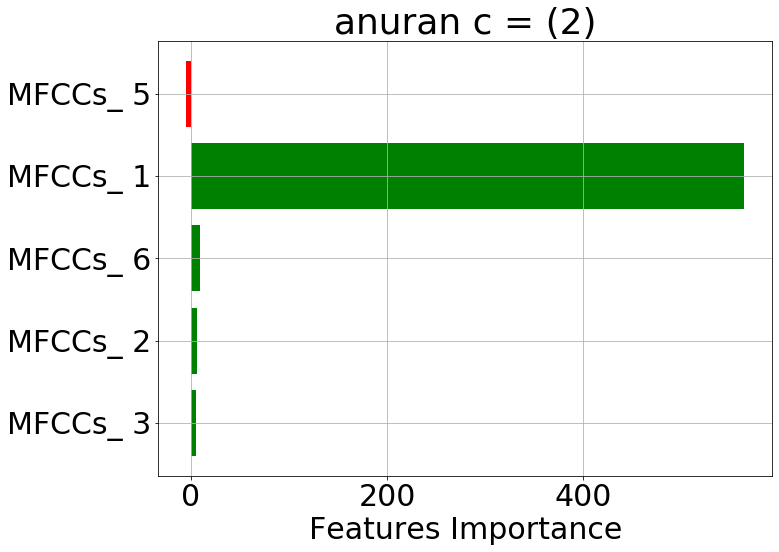

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
0.35 < MFCCs_ 3 <= 1.0  
-0.15 < MFCCs_ 9 <= 0.59  
-0.02 < MFCCs_16 <= 0.67  
-0.12 < MFCCs_ 8 <= 0.55  
-0.22 < MFCCs_ 6 <= 0.21  



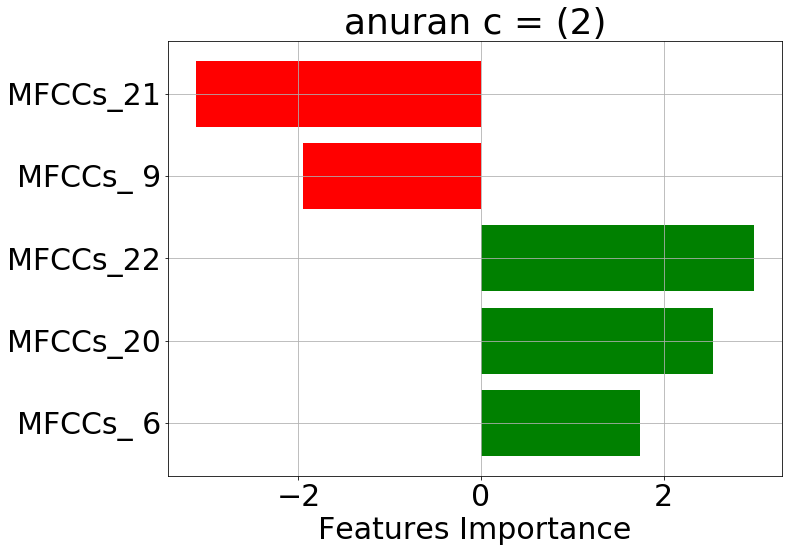

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
0.42 < MFCCs_ 4 <= 1.0  
-0.38 < MFCCs_22 <= 0.13  
-0.02 < MFCCs_16 <= 0.67  
0.23 < MFCCs_ 9 <= 0.59  
-0.73 < MFCCs_11 <= -0.18  



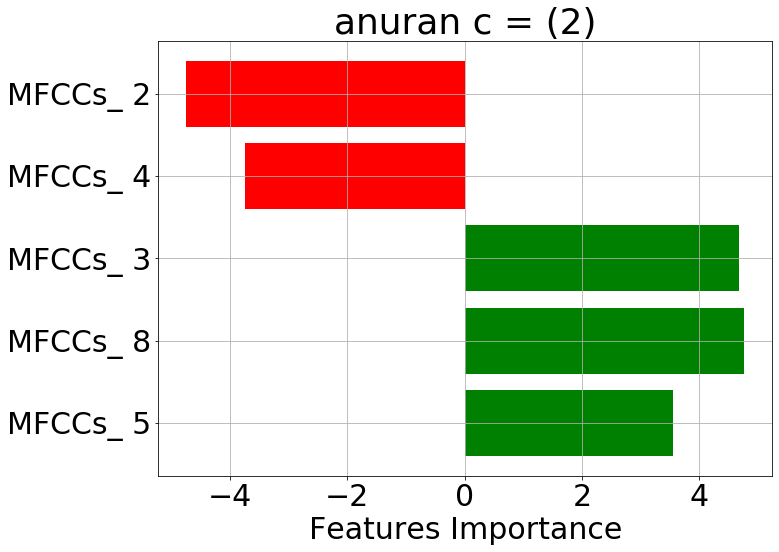

the subgroup description is :
-0.61 < MFCCs_13 <= -0.22  
-0.3 < MFCCs_ 3 <= 0.35  
-0.51 < MFCCs_18 <= -0.01  
-0.41 < MFCCs_ 8 <= -0.14  
-0.62 < MFCCs_ 2 <= 0.34  
-0.5 < MFCCs_10 <= 0.4  



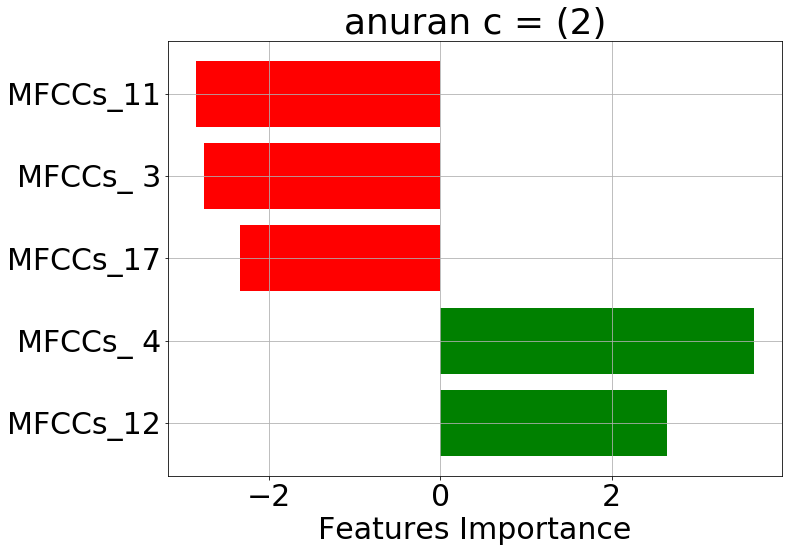

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.41 < MFCCs_ 8 <= -0.13  
-0.49 < MFCCs_ 5 <= 0.03  
0.13 < MFCCs_ 7 <= 0.62  
-0.04 < MFCCs_21 <= 0.39  
-0.26 < MFCCs_ 9 <= 0.59  



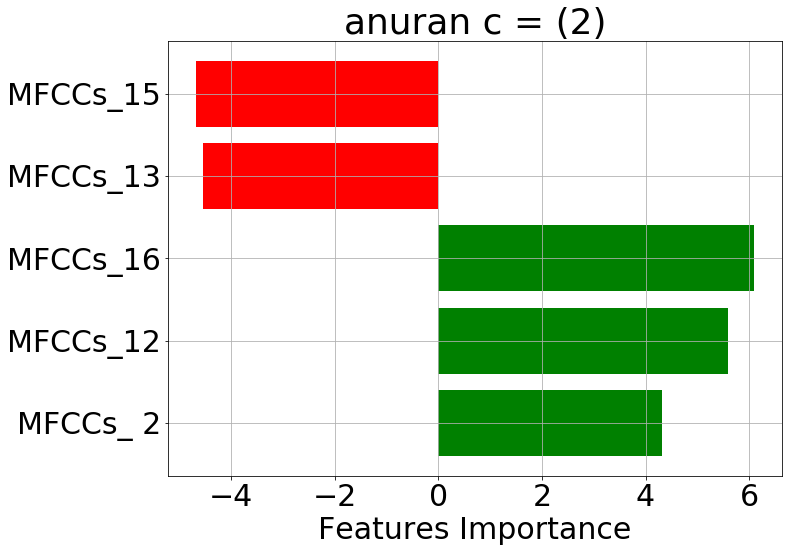

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.13 < MFCCs_ 8 <= 0.01  
-0.49 < MFCCs_ 5 <= 0.03  
-0.13 < MFCCs_14 <= 0.08  
-0.02 < MFCCs_22 <= 0.43  



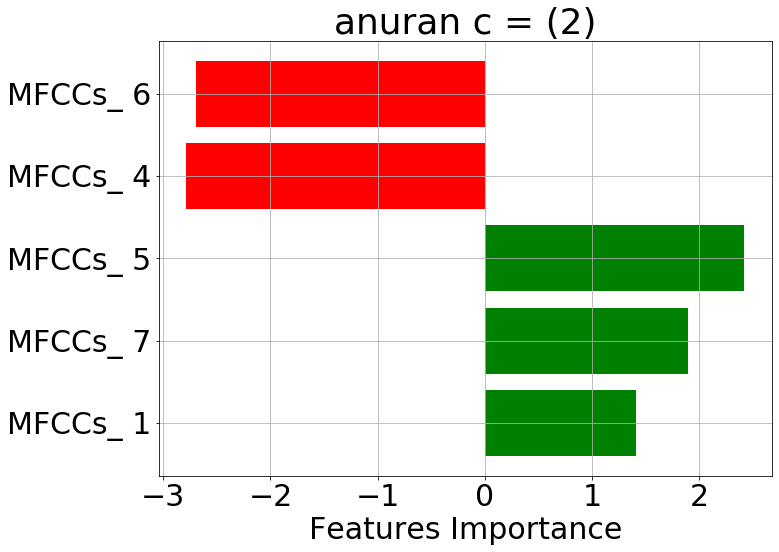

the subgroup description is :
0.13 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
-0.3 < MFCCs_ 3 <= 0.25  
-0.49 < MFCCs_ 5 <= 0.33  
-0.24 < MFCCs_10 <= 0.48  
-0.72 < MFCCs_15 <= -0.12  



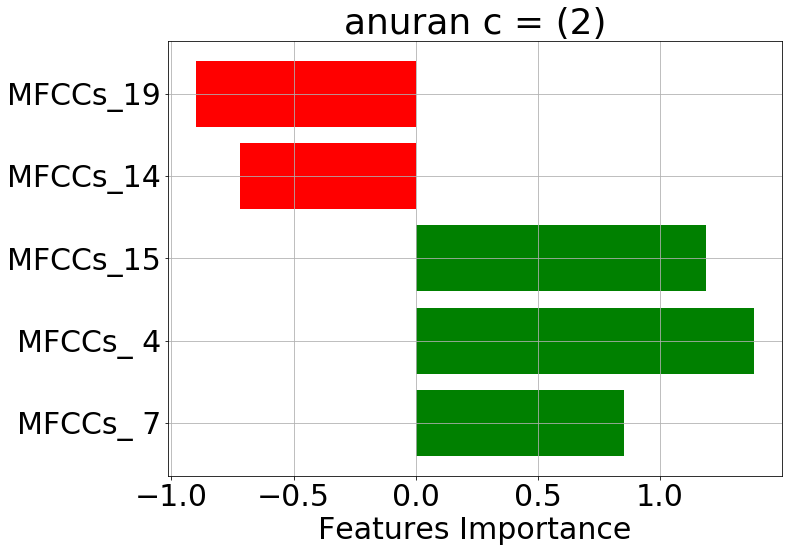

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
0.42 < MFCCs_ 4 <= 1.0  
0.13 < MFCCs_22 <= 0.43  
-0.5 < MFCCs_14 <= 0.46  



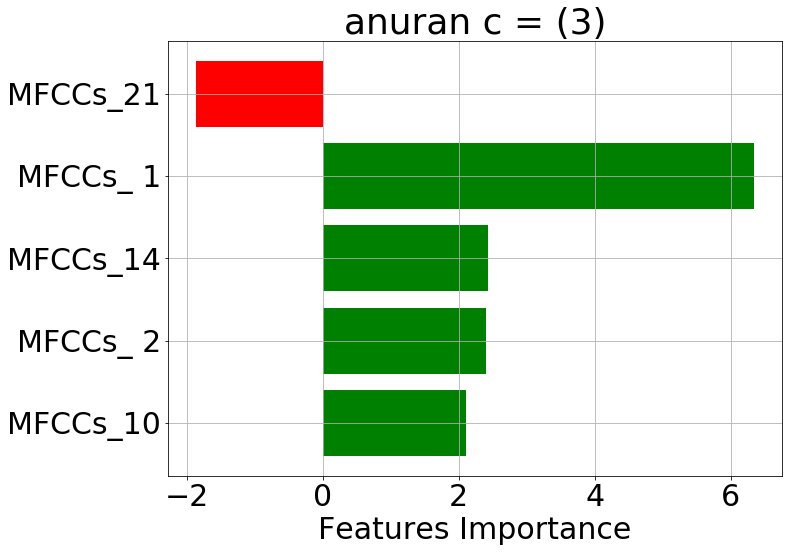

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.41 < MFCCs_ 8 <= 0.01  
0.03 < MFCCs_ 5 <= 0.53  
-0.01 < MFCCs_ 7 <= 0.62  



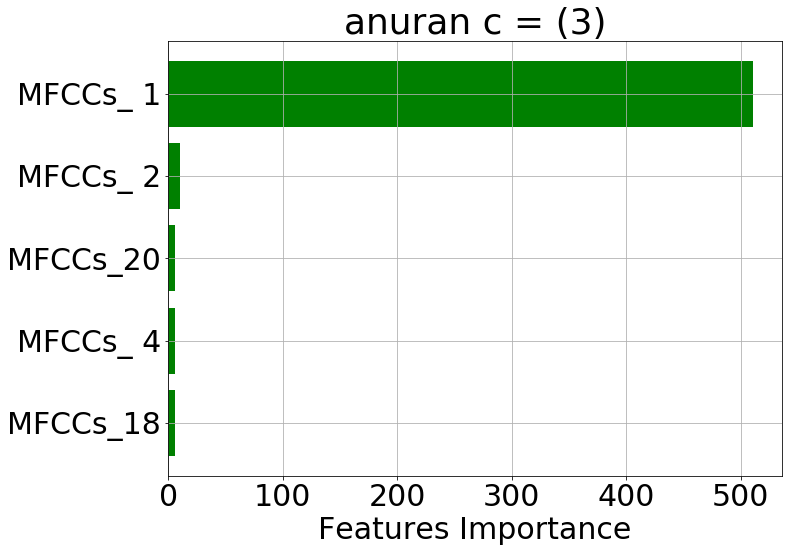

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
0.35 < MFCCs_ 3 <= 1.0  
-0.45 < MFCCs_ 9 <= -0.15  
-0.36 < MFCCs_12 <= 0.69  



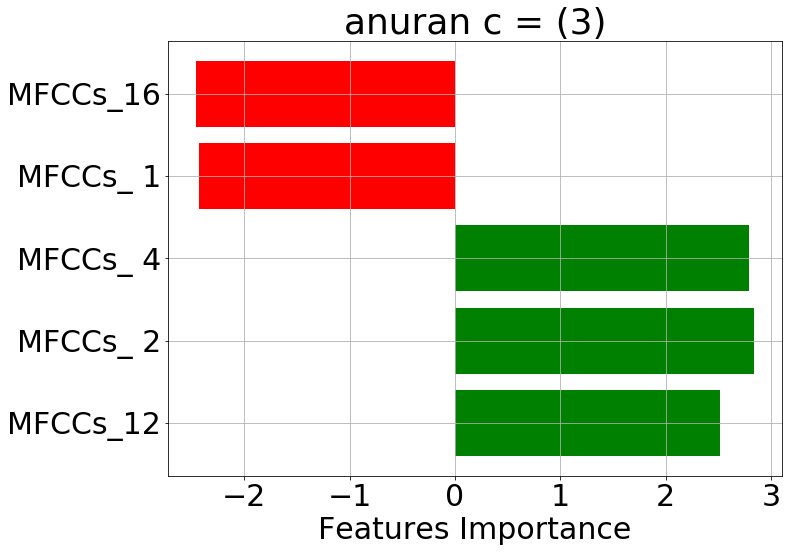

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
-0.3 < MFCCs_ 3 <= 0.35  
-0.01 < MFCCs_18 <= 0.43  
-0.37 < MFCCs_16 <= -0.05  
-0.17 < MFCCs_22 <= 0.43  



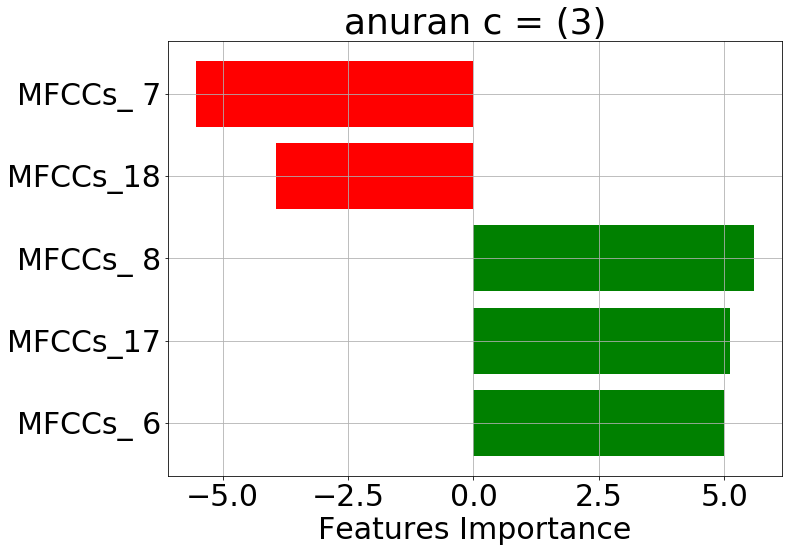

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
0.35 < MFCCs_ 3 <= 1.0  
-0.15 < MFCCs_ 9 <= 0.59  
-0.02 < MFCCs_16 <= 0.67  
-0.12 < MFCCs_ 8 <= 0.55  
-0.22 < MFCCs_ 6 <= 0.21  



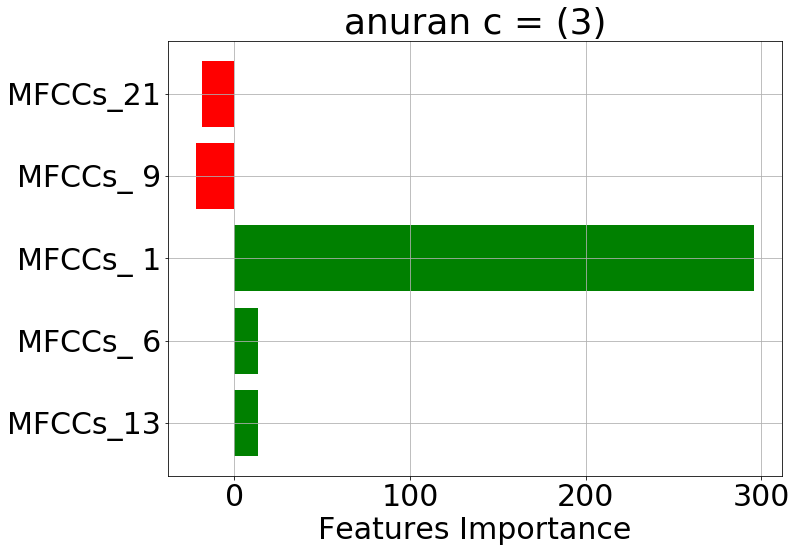

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
0.42 < MFCCs_ 4 <= 1.0  
-0.38 < MFCCs_22 <= 0.13  
-0.02 < MFCCs_16 <= 0.67  
0.23 < MFCCs_ 9 <= 0.59  
-0.73 < MFCCs_11 <= -0.18  



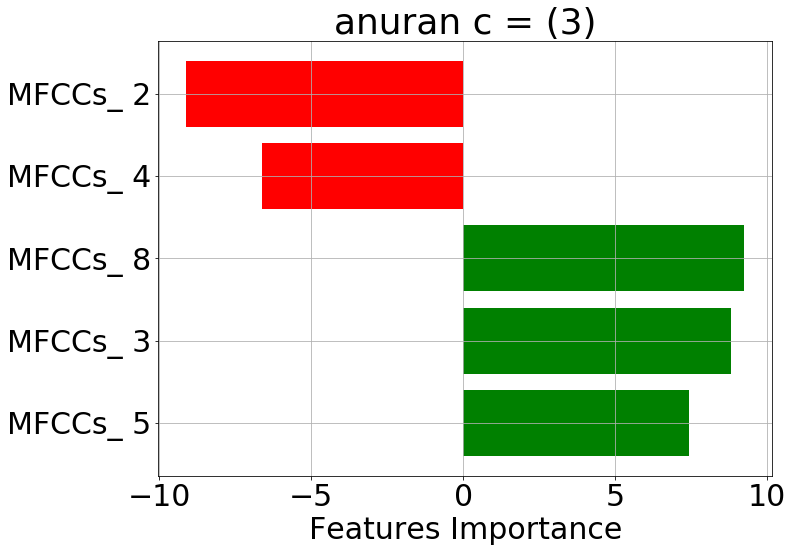

the subgroup description is :
-0.61 < MFCCs_13 <= -0.22  
-0.3 < MFCCs_ 3 <= 0.35  
-0.51 < MFCCs_18 <= -0.01  
-0.41 < MFCCs_ 8 <= -0.14  
-0.62 < MFCCs_ 2 <= 0.34  
-0.5 < MFCCs_10 <= 0.4  



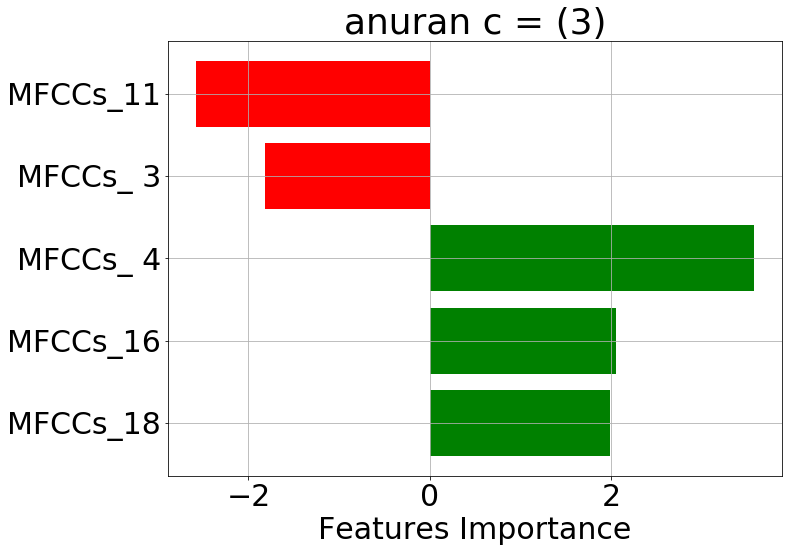

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.41 < MFCCs_ 8 <= -0.13  
-0.49 < MFCCs_ 5 <= 0.03  
0.13 < MFCCs_ 7 <= 0.62  
-0.04 < MFCCs_21 <= 0.39  
-0.26 < MFCCs_ 9 <= 0.59  



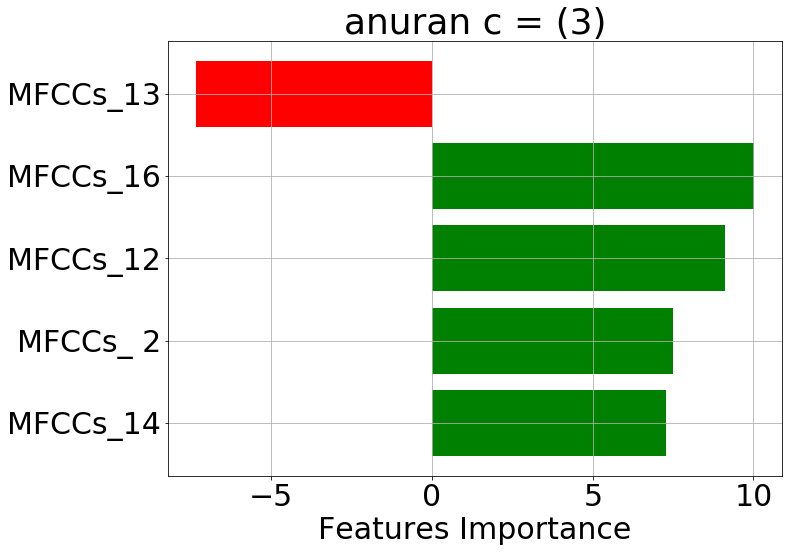

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.13 < MFCCs_ 8 <= 0.01  
-0.49 < MFCCs_ 5 <= 0.03  
-0.13 < MFCCs_14 <= 0.08  
-0.02 < MFCCs_22 <= 0.43  



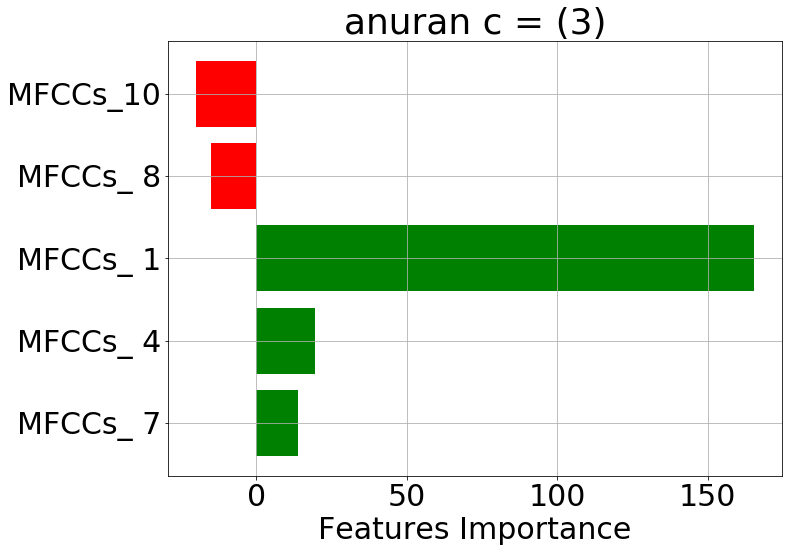

the subgroup description is :
0.13 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
-0.3 < MFCCs_ 3 <= 0.25  
-0.49 < MFCCs_ 5 <= 0.33  
-0.24 < MFCCs_10 <= 0.48  
-0.72 < MFCCs_15 <= -0.12  



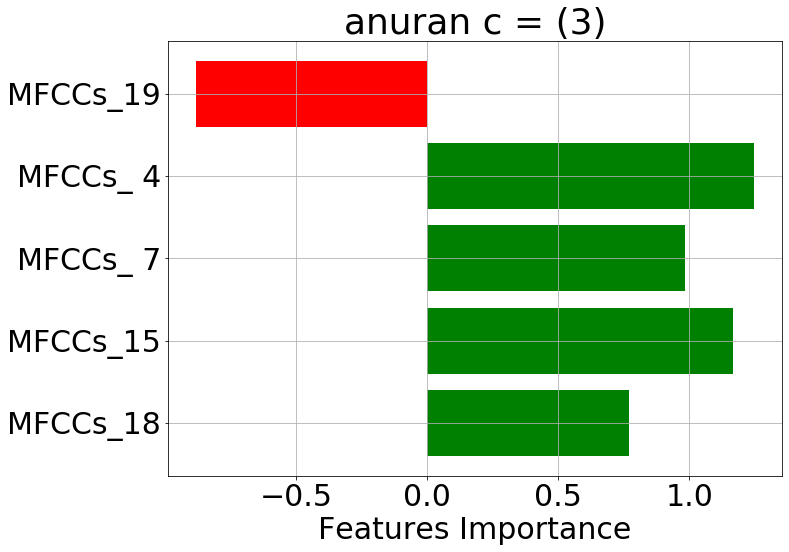

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
0.42 < MFCCs_ 4 <= 1.0  
0.13 < MFCCs_22 <= 0.43  
-0.5 < MFCCs_14 <= 0.46  



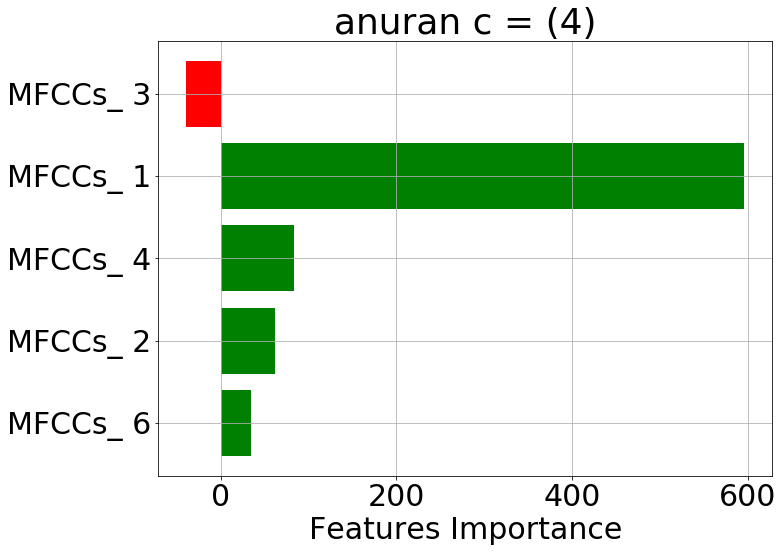

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.41 < MFCCs_ 8 <= 0.01  
0.03 < MFCCs_ 5 <= 0.53  
-0.01 < MFCCs_ 7 <= 0.62  



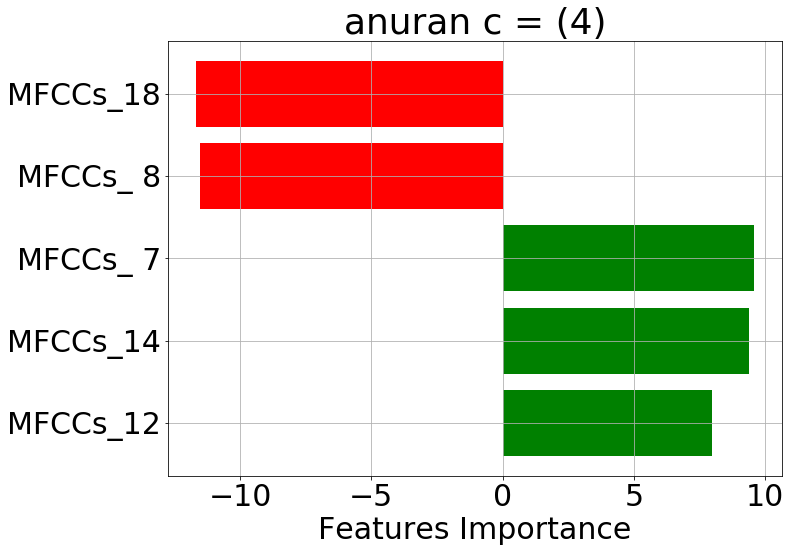

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
0.35 < MFCCs_ 3 <= 1.0  
-0.45 < MFCCs_ 9 <= -0.15  
-0.36 < MFCCs_12 <= 0.69  



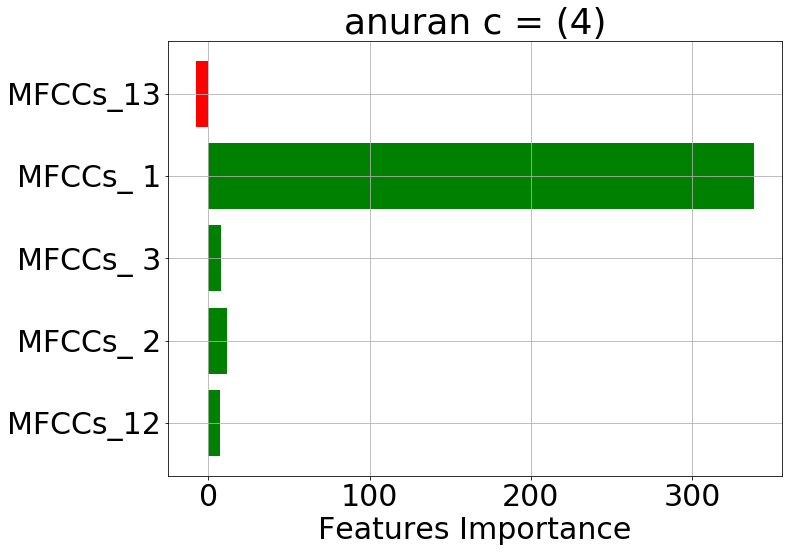

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
-0.3 < MFCCs_ 3 <= 0.35  
-0.01 < MFCCs_18 <= 0.43  
-0.37 < MFCCs_16 <= -0.05  
-0.17 < MFCCs_22 <= 0.43  



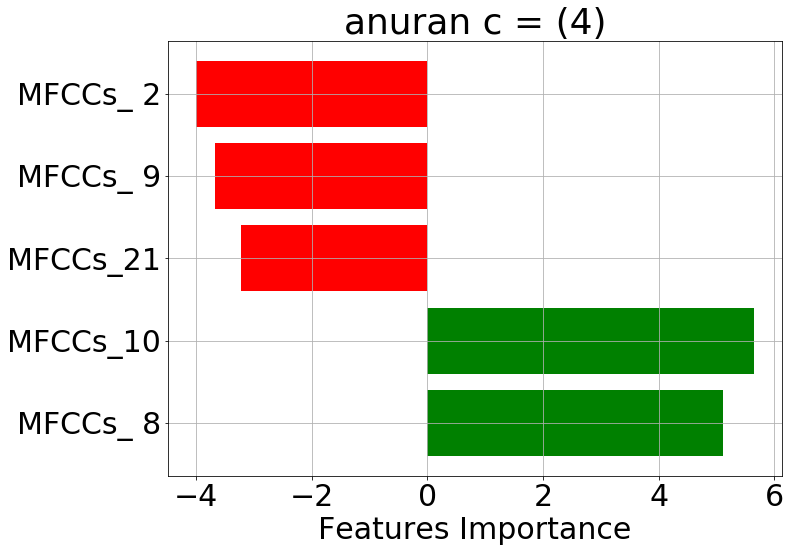

the subgroup description is :
-0.61 < MFCCs_13 <= 0.01  
0.35 < MFCCs_ 3 <= 1.0  
-0.15 < MFCCs_ 9 <= 0.59  
-0.02 < MFCCs_16 <= 0.67  
-0.12 < MFCCs_ 8 <= 0.55  
-0.22 < MFCCs_ 6 <= 0.21  



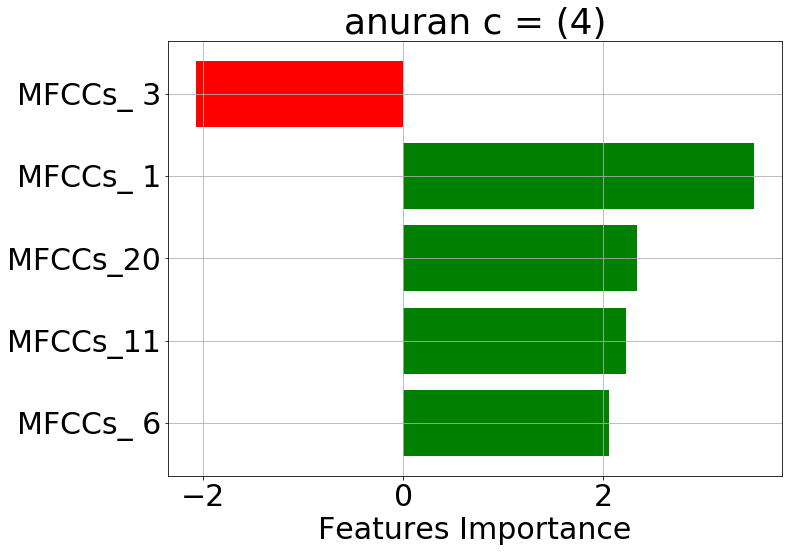

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
0.42 < MFCCs_ 4 <= 1.0  
-0.38 < MFCCs_22 <= 0.13  
-0.02 < MFCCs_16 <= 0.67  
0.23 < MFCCs_ 9 <= 0.59  
-0.73 < MFCCs_11 <= -0.18  



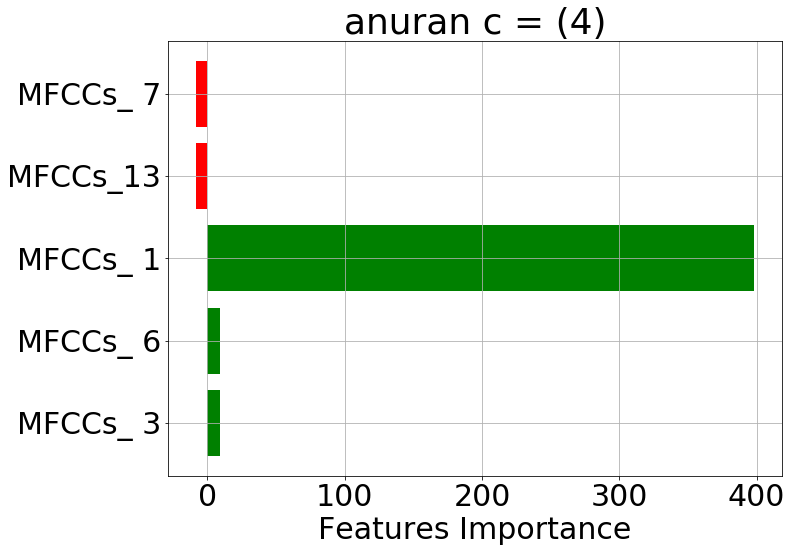

the subgroup description is :
-0.61 < MFCCs_13 <= -0.22  
-0.3 < MFCCs_ 3 <= 0.35  
-0.51 < MFCCs_18 <= -0.01  
-0.41 < MFCCs_ 8 <= -0.14  
-0.62 < MFCCs_ 2 <= 0.34  
-0.5 < MFCCs_10 <= 0.4  



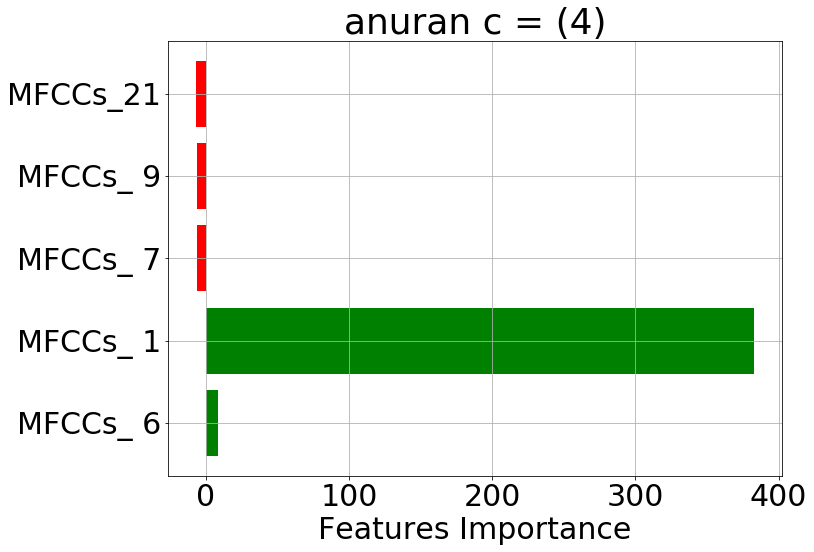

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.41 < MFCCs_ 8 <= -0.13  
-0.49 < MFCCs_ 5 <= 0.03  
0.13 < MFCCs_ 7 <= 0.62  
-0.04 < MFCCs_21 <= 0.39  
-0.26 < MFCCs_ 9 <= 0.59  



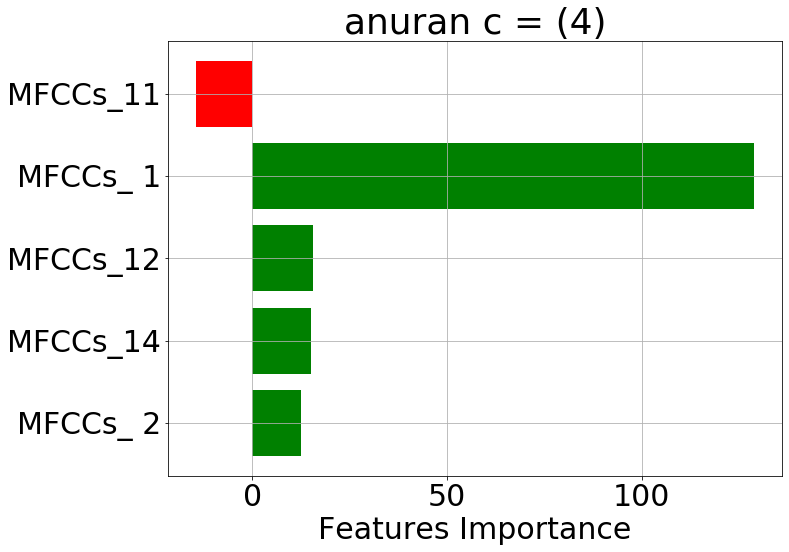

the subgroup description is :
0.01 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
0.25 < MFCCs_ 3 <= 1.0  
-0.13 < MFCCs_ 8 <= 0.01  
-0.49 < MFCCs_ 5 <= 0.03  
-0.13 < MFCCs_14 <= 0.08  
-0.02 < MFCCs_22 <= 0.43  



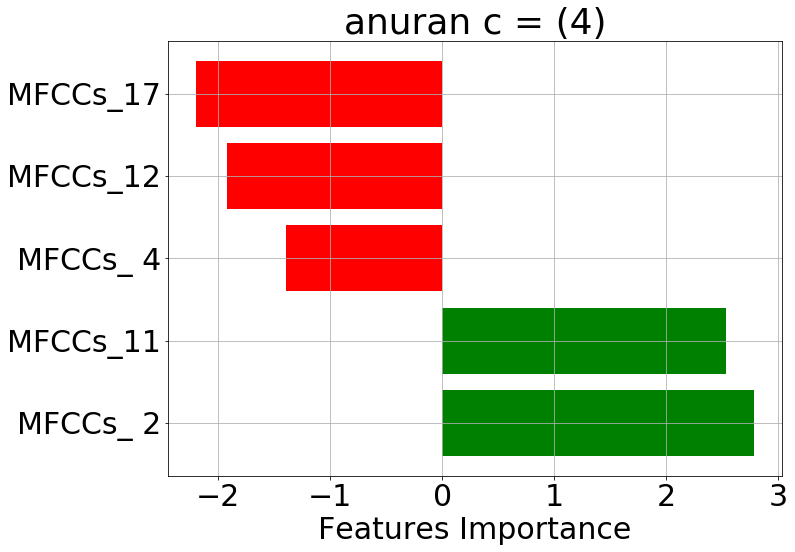

the subgroup description is :
0.13 < MFCCs_13 <= 0.95  
-0.35 < MFCCs_ 4 <= 0.42  
-0.3 < MFCCs_ 3 <= 0.25  
-0.49 < MFCCs_ 5 <= 0.33  
-0.24 < MFCCs_10 <= 0.48  
-0.72 < MFCCs_15 <= -0.12  



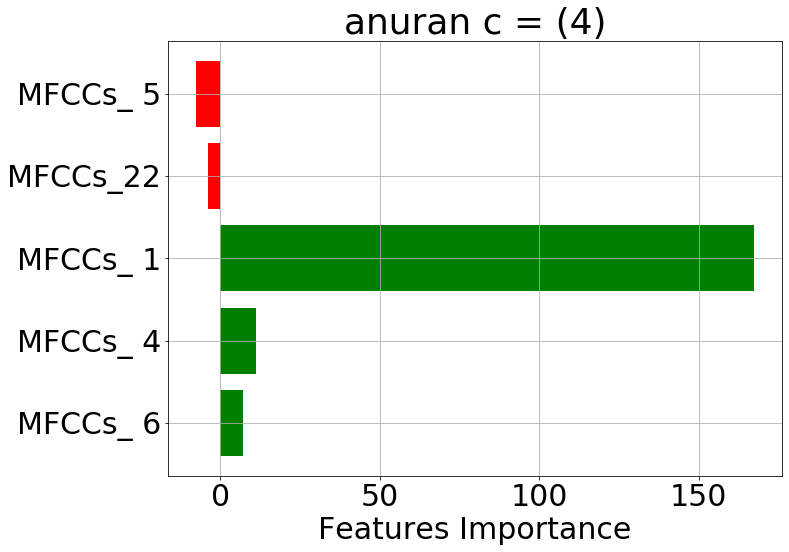

In [26]:
" We plot the features importance of the First K subgroups which covers the most instances"
K_first = 10
l_best_subgroups = sort_subgroups_support(S,K_first)

" We chose the best K features "
K_best_features = 5
for c in range(0,nb_classes) :
    plot_explanations ('anuran',W_,l_best_subgroups,att_names,patterns,K_best_features,c)

###   Comparaison with SPLIME 

#### 1. Overlapping

The average of overlapping in SPLIME is 0.619 

Red    ==   overlapping 
Green  ==   no overlapping 


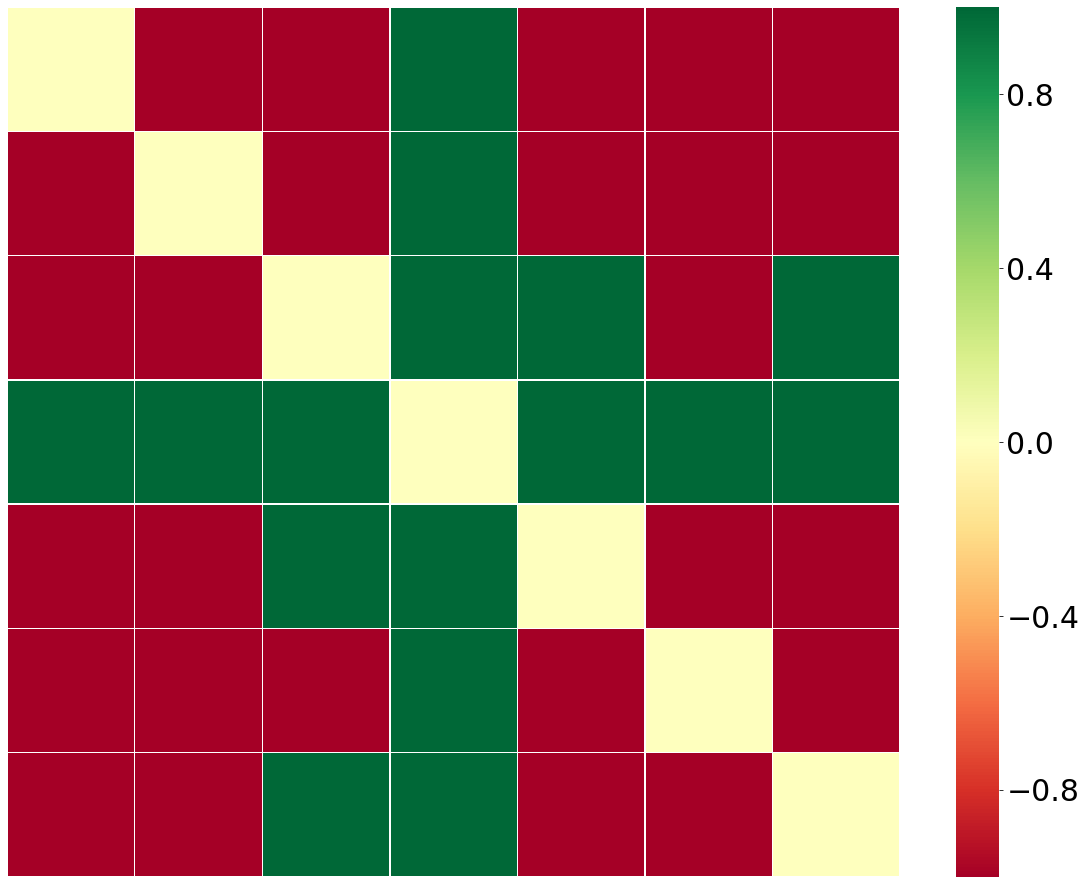

In [27]:
" We plot the matrix of overlapping "
mat_overlap = matrix_overlaps(subrgoups_splime,data_test)
print("The average of overlapping in SPLIME is", round(avg_overlaps (mat_overlap),4),'\n')

print("Red    ==   overlapping ")
print("Green  ==   no overlapping ")
f, ax = plt.subplots(figsize=(20, 16))
ax = sns.heatmap(mat_overlap,linewidths=.5,yticklabels=False,xticklabels=False,cmap ='RdYlGn',vmin=-1, vmax=1)

In [28]:
" The average on instances covers by more than one subgroup "
subrgoups_splime = sb_splime (data_test,list_neigh,model_nt)
print(" The average on instances covers by more than one subgroup is :",round(cover_more (subrgoups_splime,data_test,n),4))

 The average on instances covers by more than one subgroup is : 0.61


#### 2. Precision of SPLIME subgroups

In [29]:
" The average of precisions "
print("The average of precisions for SPLIME subgroups is :",round(sb_precision (subrgoups_splime,data_test,n),4))

The average of precisions for SPLIME subgroups is : 0.69
